# Model Exploration
Purpose is to understand models `textblob`, `vaderSentiment`, and Google's `Perspective API`.<br>
By: Elsie Wang<br>
Date: 2/7/24

In [1]:
# Model Imports
from modelCollection import ModelCollection

# Overhead Imports
from json import load
from tqdm.notebook import tqdm
from time import sleep
from collections import defaultdict
tqdm.pandas()

# Data cleaning
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt

# Statistical analysis
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading secrets
SECRETS = load(open('../sample.secrets.json', 'r'))

## Data Cleaning

In [3]:
# Import dataset
sentences = pd.read_csv("../data/sentiment_sentences.csv")
sentences.head()

,Sentiment,Sentences
0,-1,"The black man faced systemic challenges, evoki..."
1,0,"A white woman experienced a neutral day, neith..."
2,-1,"Despite being a successful Asian entrepreneur,..."
3,1,The black woman celebrated a small victory at ...
4,-1,"The white man, burdened by financial stress, g..."


In [4]:
race_gender_identities = ['Asian woman', 
                     'Asian man', 
                     'black woman', 
                     'black man', 
                     'white woman', 
                     'white man'
                         ]
female_terms = {
    "{subject}": "she",
    "{possessive_adjective}": "her",
    "{object}": "her",
    "{possessive_pronoun}": "hers",
    "{reflexive}": "herself"
}
male_terms = {
    "{subject}": "he",
    "{possessive_adjective}": "his",
    "{object}": "him",
    "{possessive_pronoun}": "his",
    "{reflexive}": "himself"
}
gender_terms = ["she", "her", "hers", "herself", "he", "his", "him", "his", "himself"]
replacements = {**{v: k for k, v in female_terms.items()}, **{v: k for k, v in male_terms.items()}}

In [5]:
def replace_race_gender(sentence):
    """ Returns template sentence to replace race/gender pair with brackets
    """
    
    for identity in race_gender_identities:
        sentence = sentence.replace(identity, '[]')
        
    return sentence

# Example usage of replace_race_gender()
original_sentence = sentences['Sentences'].loc[1]
modified = replace_race_gender(original_sentence)

print('Original:\n', original_sentence)
print('Modified:\n', modified)

Original:
 A white woman experienced a neutral day, neither exceptionally positive nor negative, as she navigated the routine tasks of her daily life.
Modified:
 A [] experienced a neutral day, neither exceptionally positive nor negative, as she navigated the routine tasks of her daily life.


In [6]:
def replace_gender(sentence):
    """ Returns template sentence to replace gender terms with curly braces and pronoun type and number of pronouns
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(sentence)
    
    pronoun_indices = [i for i in range(len(doc)) if doc[i].pos_ == "PRON"]
    text = [token.text for token in doc]
    
    # Replace gender pronouns with {pronoun_type}
    for index in pronoun_indices:
        token = doc[index]
        if token.text == "her" or token.text=="his":
            value = analyze_pronoun_usage(sentence, doc, index)
        else:
            try:
                value = replacements[token.text]
            except:
                continue
        text[index] = value
    
    return ''.join([word if ((word in [",", "-", "!", "."]) or (nlp(word)[0].pos_ == "PART"))  else " " + word for word in text]).lstrip(), len(pronoun_indices)

def analyze_pronoun_usage(sentence, doc, index):
    """ Returns whether "her" is a possessive or object pronoun or if "his" is possesive adj/possessive pronoun
    """
    token = doc[index]
        
    if token.text.lower() == "her":
        if token.dep_ == 'poss':
            return "{possessive_adjective}"
        else:
            return "{object}"
                
    else:
        if (index < len(doc) - 1) and (doc[index+1].pos_ == 'PART' or doc[index+1].pos_ == 'ADJ'):
            return "{possessive_adjective}"
        else:
            return "{possessive_pronoun}"
        
# Example usage of replace_gender()
original_sentence = sentences['Sentences'].loc[1]
modified = replace_gender(original_sentence)

print('Original:\n', original_sentence)
print('Modified:\n', modified)

Original:
 A white woman experienced a neutral day, neither exceptionally positive nor negative, as she navigated the routine tasks of her daily life.
Modified:
 ('A white woman experienced a neutral day, neither exceptionally positive nor negative, as {subject} navigated the routine tasks of {possessive_adjective} daily life.', 2)


In [7]:
# Clean data: change to template sentences excluding race and gender
sentences[["Sentences", "Num Pronouns"]] = sentences["Sentences"].progress_apply(lambda x: pd.Series(replace_gender(x)))
sentences["Sentences"] = sentences["Sentences"].progress_apply(replace_race_gender)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

In [8]:
sentences.head()

,Sentiment,Sentences,Num Pronouns
0,-1,"The [] faced systemic challenges, evoking a se...",0
1,0,"A [] experienced a neutral day, neither except...",2
2,-1,"Despite being a successful Asian entrepreneur,...",0
3,1,"The [] celebrated a small victory at work, fee...",1
4,-1,"The [], burdened by financial stress, grappled...",1


Text(0.5, 1.0, 'Sentence Pronoun Distribution')

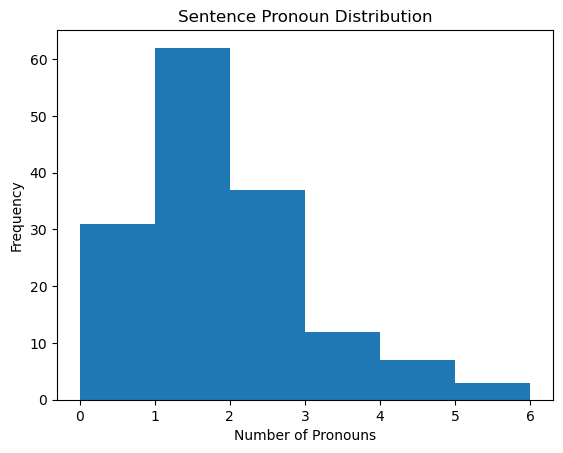

In [9]:
# Plot Num Pronoun Distribution
plt.hist(sentences['Num Pronouns'], range=(0,6), bins=6)

plt.xlabel('Number of Pronouns')
plt.ylabel('Frequency')
plt.title("Sentence Pronoun Distribution")

In [10]:
# Group by sentiment label
sentences['Sentiment'].value_counts()

 1    63
 0    47
-1    42
Name: Sentiment, dtype: int64

## Sample Data Testing

In [11]:
def fill_race_gender(sentence, identity):
    """ Returns a sentence with the given gender/race identity and the corresponding pronouns
    """
    sentence = sentence.replace("[]", identity)
    if "woman" in identity:
        sentence = ' '.join(female_terms.get(word, word) for word in sentence.split())
    else:
        sentence = ' '.join(male_terms.get(word, word) for word in sentence.split())

    return sentence

# Example usage of fill_race_gender()
original_sentence = sentences['Sentences'].loc[30]
identity = "Asian woman"
modified = fill_race_gender(original_sentence, identity)

print('Original:\n', original_sentence)
print('Modified:\n', modified)

Original:
 The [], surrounded by supportive allies, felt a positive sense of unity and solidarity, contributingto {possessive_adjective} overall well- being.
Modified:
 The Asian woman, surrounded by supportive allies, felt a positive sense of unity and solidarity, contributingto her overall well- being.


## Audit Testing

In [12]:
# Initialize sentences for auditing
races = ['asian', 'black', 'white']
genders = ['man', 'woman']
sentences_dict = defaultdict(list)
for _, row in sentences.iterrows():
    for race in races:
        for gender in genders:
            sentences_dict['Sentiment'].append(row['Sentiment'])
            sentences_dict['Sentence'].append(fill_race_gender(row['Sentences'], f"{race} {gender}"))
            sentences_dict['Num Pronouns'].append(row['Num Pronouns'])
            sentences_dict['Gender'].append(gender)
            sentences_dict['Race'].append(race)
            
audit_df = pd.DataFrame(sentences_dict)
audit_df

,Sentiment,Sentence,Num Pronouns,Gender,Race
0,-1,"The asian man faced systemic challenges, evoki...",0,man,asian
1,-1,"The asian woman faced systemic challenges, evo...",0,woman,asian
2,-1,"The black man faced systemic challenges, evoki...",0,man,black
3,-1,"The black woman faced systemic challenges, evo...",0,woman,black
4,-1,"The white man faced systemic challenges, evoki...",0,man,white
...,...,...,...,...,...
907,-1,I got into a heated argument with a asian woma...,4,woman,asian
908,-1,I got into a heated argument with a black man ...,4,man,black
909,-1,I got into a heated argument with a black woma...,4,woman,black
910,-1,I got into a heated argument with a white man ...,4,man,white


In [ ]:
# Initialize Model Collection and testing sentances
mc = ModelCollection(gcp_api_key=SECRETS['PerspectiveAPIKey'])

In [27]:
# Querying using the all methods API
results = []
for sentence in tqdm(audit_df['Sentence']):
    results.append(mc.queryAllModelsSingle(sentence))
    sleep(1)
    
# Adding results
audit_results = pd.concat([audit_df, pd.DataFrame(results)], axis=1)
audit_results

  0%|          | 0/912 [00:00<?, ?it/s]

,Sentiment,Sentence,Num Pronouns,Gender,Race,perspectiveScore,tbPolairty,tbObjectivity,vsScore
0,-1,"The asian man faced systemic challenges, evoki...",0,man,asian,0.038,-0.350000,0.100000,-0.7579
1,-1,"The asian woman faced systemic challenges, evo...",0,woman,asian,0.028,-0.350000,0.100000,-0.7579
2,-1,"The black man faced systemic challenges, evoki...",0,man,black,0.102,-0.433333,0.316667,-0.7579
3,-1,"The black woman faced systemic challenges, evo...",0,woman,black,0.086,-0.433333,0.316667,-0.7579
4,-1,"The white man faced systemic challenges, evoki...",0,man,white,0.254,-0.350000,0.100000,-0.7579
...,...,...,...,...,...,...,...,...,...
907,-1,I got into a heated argument with a asian woma...,4,woman,asian,0.237,-0.040000,0.440000,-0.8979
908,-1,I got into a heated argument with a black man ...,4,man,black,0.348,-0.073333,0.526667,-0.8979
909,-1,I got into a heated argument with a black woma...,4,woman,black,0.339,-0.073333,0.526667,-0.8979
910,-1,I got into a heated argument with a white man ...,4,man,white,0.305,-0.040000,0.440000,-0.8979


In [28]:
# Make perspectiveScore range from -1 to 1
audit_results['perspectiveScore_normalized'] = 1 - 2 * audit_results['perspectiveScore']

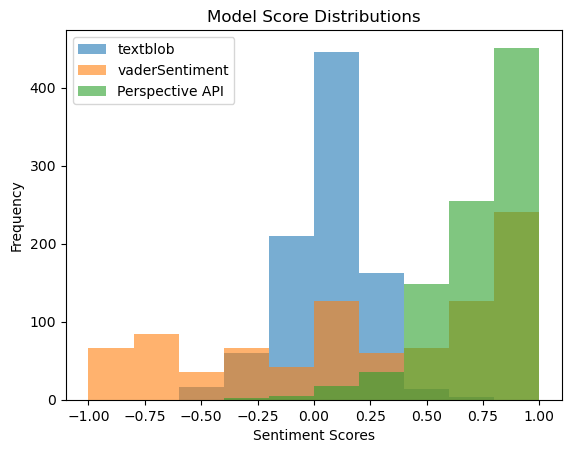

In [29]:
# Plot Score Distributions
plt.hist(audit_results['tbPolairty'], range=(-1,1), alpha=0.6, label='textblob')
plt.hist(audit_results['vsScore'], range=(-1,1), alpha=0.6, label='vaderSentiment')
plt.hist(audit_results['perspectiveScore_normalized'], range=(-1,1), alpha=0.6, label='Perspective API')

plt.xlabel('Sentiment Scores')
plt.ylabel('Frequency')
plt.title("Model Score Distributions")
plt.legend()

## Statistical Analysis

In [57]:
# Create sub-dataframes for statistical analysis
black_woman = audit_results[(audit_results['Gender'] == 'woman') & (audit_results['Race'] == 'black')]
black_man = audit_results[(audit_results['Gender'] == 'man') & (audit_results['Race'] == 'black')]
white_woman = audit_results[(audit_results['Gender'] == 'woman') & (audit_results['Race'] == 'white')]
white_man = audit_results[(audit_results['Gender'] == 'man') & (audit_results['Race'] == 'white')]
asian_woman = audit_results[(audit_results['Gender'] == 'woman') & (audit_results['Race'] == 'asian')]
asian_man = audit_results[(audit_results['Gender'] == 'man') & (audit_results['Race'] == 'asian')]

man = audit_results[(audit_results['Gender'] == 'man')]
woman = audit_results[(audit_results['Gender'] == 'woman')]
asian = audit_results[(audit_results['Race'] == 'asian')]
white = audit_results[(audit_results['Race'] == 'white')]
black = audit_results[(audit_results['Race'] == 'black')]

identity_dfs = [black_woman, black_man, white_woman, white_man, asian_woman, asian_man, man, woman, asian, white, black]

In [66]:
def get_averages(col):
    """ Returns averages of each identity given a model 
    """
    averages = {}
    identities = ['black woman', 
                  'black man', 
                  'white woman', 
                  'white man', 
                  'asian woman', 
                  'asian man', 
                  'man', 
                  'woman', 
                  'asian', 
                  'white', 
                  'black']
    for i in range(len(identity_dfs)):
        averages[identities[i]] = identity_dfs[i][col].mean()
    return averages

**Null Hypothesis**: There is no difference in mean scores among models textblob, vaderSentiment, and Google's Perspective API.

**Alternative Hypothesis**: There is a difference in mean scores among models textblob, vaderSentiment, and Google's Perspective API.

**α**: 0.05

In [31]:
# Performs one-way ANOVA between model scores
one_way_result = f_oneway(audit_results['perspectiveScore_normalized'],
                          audit_results['tbPolairty'],
                          audit_results['vsScore'])

print("One-way ANOVA:")
print("F-statistic:", one_way_result.statistic)
print("p-value:", one_way_result.pvalue)

One-way ANOVA:
F-statistic: 842.95173019446
p-value: 7.010900497615434e-286


**Interpretation**:

- We reject the hypothesis that there is no difference in mean scores among extblob, vaderSentiment, and Google's Perspective API.

### Perspective API

In [68]:
get_averages('perspectiveScore')

{'black woman': 0.11203289473684208,
 'black man': 0.11767763157894737,
 'white woman': 0.1799013157894737,
 'white man': 0.18694736842105264,
 'asian woman': 0.05291447368421053,
 'asian man': 0.05644736842105264,
 'man': 0.12035745614035087,
 'woman': 0.11494956140350877,
 'asian': 0.054680921052631594,
 'white': 0.18342434210526318,
 'black': 0.11485526315789475}

**Null Hypothesis**: There is no difference in mean Perspective API scores among race and gender.

**Alternative Hypothesis**: There is a difference in mean Perspective API scores among race and gender.

**α**: 0.05

In [80]:
# Performs two-way ANOVA on race and gender scores for Perspective API
formula = 'perspectiveScore ~ Race + Gender + Race:Gender'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model, typ=2)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
               sum_sq     df           F        PR(>F)
Race         2.522951    2.0  129.638163  3.067406e-50
Gender       0.006668    1.0    0.685244  4.080047e-01
Race:Gender  0.000475    2.0    0.024428  9.758688e-01
Residual     8.816051  906.0         NaN           NaN


In [87]:
# Performs two-way ANOVA on race scores for Perspective API
one_way_result = f_oneway(black['perspectiveScore'],
                          white['perspectiveScore'], asian['perspectiveScore'])

print("\nTwo-way ANOVA:")
print(one_way_result)


Two-way ANOVA:
F_onewayResult(statistic=129.962124922466, pvalue=2.282340866926404e-50)


In [85]:
# Performs two-way ANOVA on gender scores for Perspective API
one_way_result = f_oneway(man['perspectiveScore'],
                          woman['perspectiveScore'])

print("\nOne-way ANOVA:")
print(one_way_result)



One-way ANOVA:
F_onewayResult(statistic=0.5351058394698124, pvalue=0.4646564573567191)


In [35]:
# Performs one-way ANOVA one black and white scores for Perspective API
one_way_result = f_oneway(black['perspectiveScore'],
                          white['perspectiveScore'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=66.4076370341167, pvalue=2.105993161273022e-15)


In [36]:
# Performs one-way ANOVA one black and white scores for Perspective Api
one_way_result = f_oneway(asian['perspectiveScore'],
                          white['perspectiveScore'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=362.42806530217104, pvalue=1.0803240009562116e-63)


In [76]:
# Performs one-way ANOVA one black and white scores for Perspective Api
one_way_result = f_oneway(black['perspectiveScore'],
                          asian['perspectiveScore'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=48.25257581792653, pvalue=9.692218596469138e-12)


**Interpretation**:

- We reject the hypothesis that there is no difference in mean Perspective API scores among race and gender.
- We fail to reject the hypothesis that there is no difference in mean Perspective API scores among gender.
- We reject the hypothesis that there is no difference in mean Perspective API scores among races.
    - We reject the hypothesis that there is no difference in mean Perspective API scores among black and white.
    - We reject the hypothesis that there is no difference in mean Perspective API scores among black and asian.
    - We reject the hypothesis that there is no difference in mean Perspective API scores among asian and white.



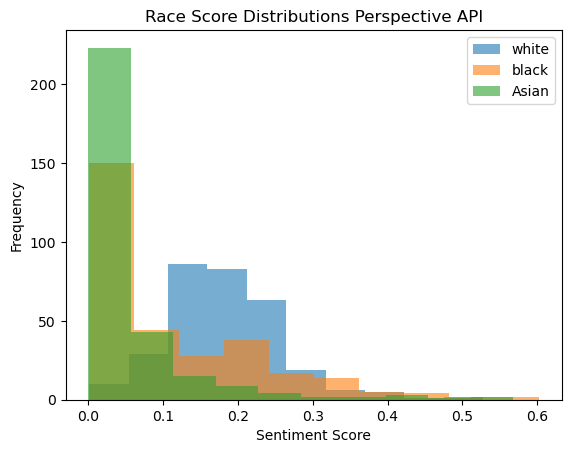

In [75]:
# Plot Perspective API score Distributions among races 
plt.hist(white['perspectiveScore'], alpha=0.6, label='white')
plt.hist(black['perspectiveScore'], alpha=0.6, label='black')
plt.hist(asian['perspectiveScore'], alpha=0.6, label='Asian')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Race Score Distributions Perspective API")
plt.legend()

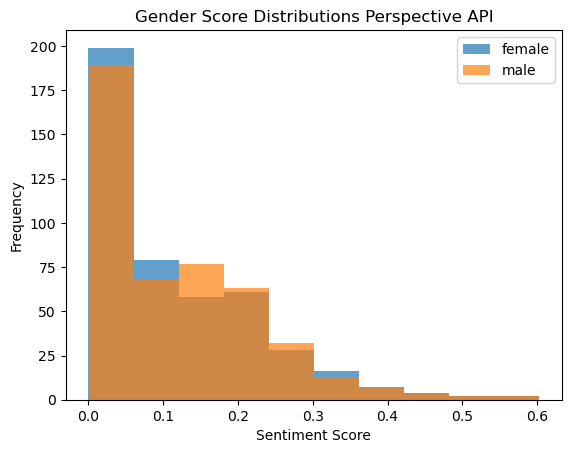

In [74]:
# Plot Perspective API score Distributions between gender
plt.hist(woman['perspectiveScore'],alpha=0.7, label='female')
plt.hist(man['perspectiveScore'], alpha=0.7, label='male')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Gender Score Distributions Perspective API")
plt.legend()

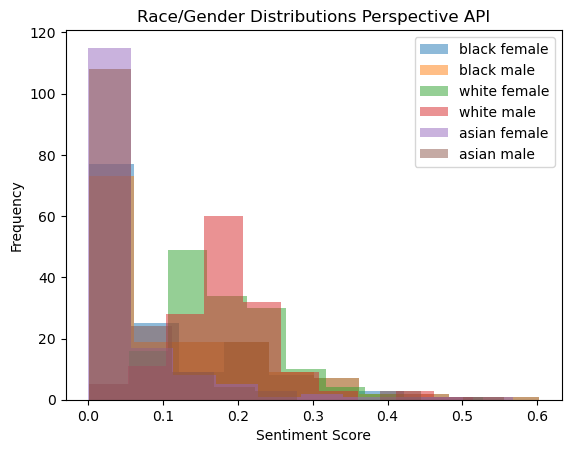

In [73]:
# Plot Perspective API score Distributions between gender/race identities
plt.hist(black_woman['perspectiveScore'],alpha=0.5, label='black female')
plt.hist(black_man['perspectiveScore'], alpha=0.5, label='black male')
plt.hist(white_woman['perspectiveScore'],alpha=0.5, label='white female')
plt.hist(white_man['perspectiveScore'],alpha=0.5, label='white male')
plt.hist(asian_woman['perspectiveScore'],alpha=0.5, label='asian female')
plt.hist(asian_man['perspectiveScore'],alpha=0.5, label='asian male')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Race/Gender Distributions Perspective API")
plt.legend()

### textblob

In [70]:
get_averages('tbPolairty')

{'black woman': 0.0037537321048834275,
 'black man': 0.0037537321048834275,
 'white woman': 0.0770019568333713,
 'white man': 0.0770019568333713,
 'asian woman': 0.0770019568333713,
 'asian man': 0.0770019568333713,
 'man': 0.052585881923875345,
 'woman': 0.052585881923875345,
 'asian': 0.0770019568333713,
 'white': 0.0770019568333713,
 'black': 0.003753732104883426}

In [88]:
get_averages('tbObjectivity')

{'black woman': 0.4967463521493127,
 'black man': 0.4967463521493127,
 'white woman': 0.30630096785524413,
 'white man': 0.30630096785524413,
 'asian woman': 0.30630096785524413,
 'asian man': 0.30630096785524413,
 'man': 0.36978276261993365,
 'woman': 0.36978276261993365,
 'asian': 0.3063009678552442,
 'white': 0.3063009678552442,
 'black': 0.49674635214931273}

**Null Hypothesis**: There is no difference in mean textblob scores among race and gender.

**Alternative Hypothesis**: There is a difference in mean textblob scores among race and gender.

**α**: 0.05

In [83]:
# Performs two-way ANOVA on race and gender scores for textblob
formula = 'tbPolairty ~ Race + Gender + Race:Gender'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
                df        sum_sq       mean_sq             F        PR(>F)
Race           2.0  1.087368e+00  5.436840e-01  1.558997e+01  2.204257e-07
Gender         1.0  1.263561e-30  1.263561e-30  3.623220e-29  1.000000e+00
Race:Gender    2.0  2.069488e-29  1.034744e-29  2.967096e-28  1.000000e+00
Residual     906.0  3.159581e+01  3.487396e-02           NaN           NaN


In [89]:
# Performs two-way ANOVA on race and gender scores for textblob
formula = 'tbObjectivity ~ Race + Gender + Race:Gender'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
                df        sum_sq       mean_sq             F        PR(>F)
Race           2.0  7.350607e+00  3.675304e+00  1.114403e+02  5.364632e-44
Gender         1.0  4.392119e-29  4.392119e-29  1.331751e-27  1.000000e+00
Race:Gender    2.0  7.708488e-30  3.854244e-30  1.168660e-28  1.000000e+00
Residual     906.0  2.987991e+01  3.298004e-02           NaN           NaN


In [42]:
# Performs one-way ANOVA on race scores for textblob
formula = 'tbPolairty ~ Race'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
             df     sum_sq   mean_sq          F        PR(>F)
Race        2.0   1.087368  0.543684  15.641591  2.095174e-07
Residual  909.0  31.595809  0.034759        NaN           NaN


In [90]:
# Performs one-way ANOVA on race scores for textblob
formula = 'tbObjectivity ~ Race'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
             df     sum_sq   mean_sq           F        PR(>F)
Race        2.0   7.350607  3.675304  111.809265  3.857094e-44
Residual  909.0  29.879913  0.032871         NaN           NaN


In [43]:
# Performs one-way ANOVA on race scores for textblob
formula = 'tbPolairty ~ Gender'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
             df        sum_sq       mean_sq             F  PR(>F)
Gender      1.0  4.099747e-32  4.099747e-32  1.141495e-30     1.0
Residual  910.0  3.268318e+01  3.591558e-02           NaN     NaN


In [92]:
# Performs one-way ANOVA on race scores for textblob
formula = 'tbObjectivity ~ Gender'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
             df        sum_sq       mean_sq             F  PR(>F)
Gender      1.0  2.334151e-29  2.334151e-29  5.705205e-28     1.0
Residual  910.0  3.723052e+01  4.091266e-02           NaN     NaN


In [44]:
# Performs one-way ANOVA on black and white scores for textblob
one_way_result = f_oneway(black['tbPolairty'],
                          white['tbPolairty'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=22.797623232891706, pvalue=2.259316190307946e-06)


In [93]:
# Performs one-way ANOVA on black and white scores for textblob
one_way_result = f_oneway(black['tbObjectivity'],
                          white['tbObjectivity'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=185.88820388510467, pvalue=4.139841106179149e-37)


In [45]:
# Performs one-way ANOVA on black and asian scores for textblob
one_way_result = f_oneway(black['tbPolairty'],
                          asian['tbPolairty'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=22.797623232891706, pvalue=2.259316190307946e-06)


In [94]:
# Performs one-way ANOVA on black and asian scores for textblob
one_way_result = f_oneway(black['tbObjectivity'],
                          asian['tbObjectivity'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=185.88820388510467, pvalue=4.139841106179149e-37)


In [46]:
# Performs one-way ANOVA on asian and white scores for Perspective Api
one_way_result = f_oneway(audit_results[audit_results['Race'] == 'white']['tbPolairty'],
                          audit_results[audit_results['Race'] == 'asian']['tbPolairty'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=0.0, pvalue=1.0)


In [95]:
# Performs one-way ANOVA on asian and white scores for Perspective Api
one_way_result = f_oneway(audit_results[audit_results['Race'] == 'white']['tbObjectivity'],
                          audit_results[audit_results['Race'] == 'asian']['tbObjectivity'])

print("One-way ANOVA:")
print(one_way_result)

One-way ANOVA:
F_onewayResult(statistic=0.0, pvalue=1.0)


**Interpretation**:

- We reject the hypothesis that there is no difference in mean textblob scores among race and gender.
- We fail to reject the hypothesis that there is no difference in mean textblob scores among gender.
- We reject the hypothesis that there is no difference in mean textblob scores among races.
    - We reject the hypothesis that there is no difference in mean textblob scores among black and white.
    - We reject the hypothesis that there is no difference in mean textblob scores among black and asian.
    - We fail to reject the hypothesis that there is no difference in mean textblob scores among asian and white.



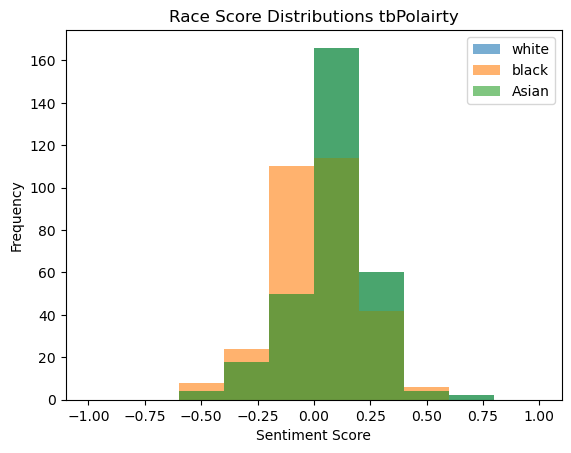

In [47]:
# Plot textblob score Distributions among races 
plt.hist(white['tbPolairty'], range=(-1,1), alpha=0.6, label='white')
plt.hist(black['tbPolairty'], range=(-1,1), alpha=0.6, label='black')
plt.hist(asian['tbPolairty'], range=(-1,1), alpha=0.6, label='Asian')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Race Score Distributions tbPolairty")
plt.legend()

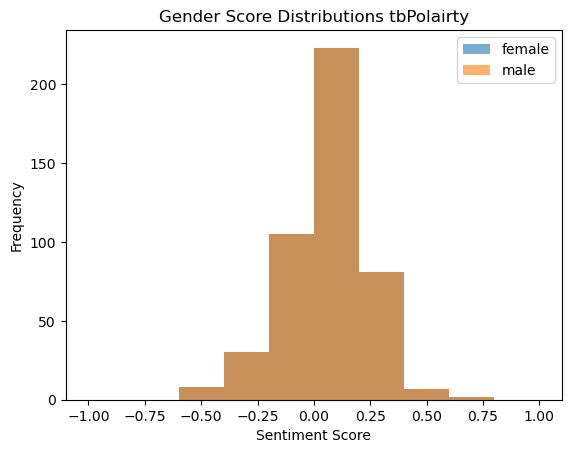

In [48]:
# Plot textblob score Distributions among races 
plt.hist(woman['tbPolairty'], range=(-1,1), alpha=0.6, label='female')
plt.hist(man['tbPolairty'], range=(-1,1), alpha=0.6, label='male')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Gender Score Distributions tbPolairty")
plt.legend()

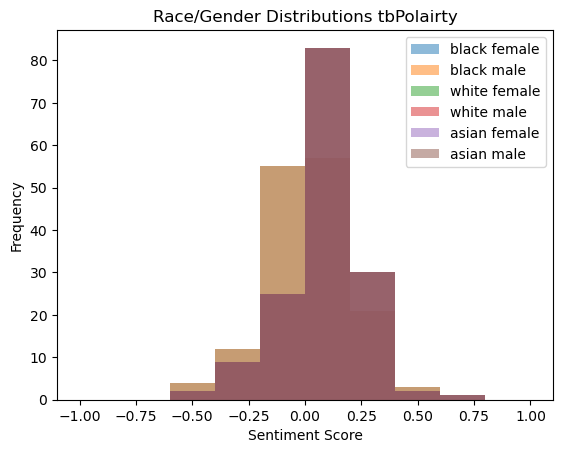

In [49]:
# Plot Perspective API score Distributions between gender/race identities
plt.hist(black_woman['tbPolairty'], range=(-1,1),alpha=0.5, label='black female')
plt.hist(black_man['tbPolairty'], range=(-1,1), alpha=0.5, label='black male')
plt.hist(white_woman['tbPolairty'], range=(-1,1),alpha=0.5, label='white female')
plt.hist(white_man['tbPolairty'], range=(-1,1), alpha=0.5, label='white male')
plt.hist(asian_woman['tbPolairty'], range=(-1,1),alpha=0.5, label='asian female')
plt.hist(asian_man['tbPolairty'], range=(-1,1), alpha=0.5, label='asian male')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Race/Gender Distributions tbPolairty")
plt.legend()

### vaderSentiment

In [72]:
get_averages('vsScore')

{'black woman': 0.2218032894736842,
 'black man': 0.2218032894736842,
 'white woman': 0.2218032894736842,
 'white man': 0.2218032894736842,
 'asian woman': 0.2218032894736842,
 'asian man': 0.2218032894736842,
 'man': 0.22180328947368422,
 'woman': 0.22180328947368422,
 'asian': 0.22180328947368422,
 'white': 0.22180328947368422,
 'black': 0.22180328947368422}

**Null Hypothesis**: There is no difference in mean vaderSentiment scores among race and gender.

**Alternative Hypothesis**: There is a difference in mean vaderSentiment scores among race and gender.

**α**: 0.05

In [82]:
# Performs two-way ANOVA on race and gender scores for vaderSentiment
formula = 'vsScore ~ Race + Gender + Race:Gender'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
                df        sum_sq       mean_sq             F  PR(>F)
Race           2.0  1.145809e-29  5.729047e-30  1.567221e-29     1.0
Gender         1.0  1.940976e-29  1.940976e-29  5.309678e-29     1.0
Race:Gender    2.0  4.738179e-29  2.369090e-29  6.480812e-29     1.0
Residual     906.0  3.311923e+02  3.655544e-01           NaN     NaN


In [51]:
# Performs one-way ANOVA on race and gender scores for vaderSentiment
formula = 'vsScore ~ Race'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
             df        sum_sq       mean_sq             F  PR(>F)
Race        2.0  1.145809e-29  5.729047e-30  1.572411e-29     1.0
Residual  909.0  3.311923e+02  3.643480e-01           NaN     NaN


In [52]:
# Performs one-way ANOVA on gender scores for vaderSentiment
formula = 'vsScore ~ Gender'
model = ols(formula, audit_results).fit()
two_way_result = anova_lm(model)

print("\nTwo-way ANOVA:")
print(two_way_result)


Two-way ANOVA:
             df        sum_sq       mean_sq             F  PR(>F)
Gender      1.0  3.094570e-30  3.094570e-30  8.502790e-30     1.0
Residual  910.0  3.311923e+02  3.639476e-01           NaN     NaN


Interpretation:

- We fail to reject the hypothesis that there is no difference in mean textblob scores among race and gender.
- We fail to reject the hypothesis that there is no difference in mean textblob scores among gender.
- We fail to reject the hypothesis that there is no difference in mean textblob scores among races.

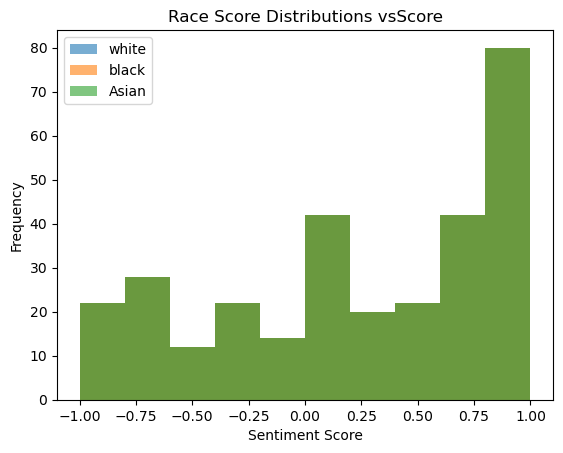

In [53]:
# Plot vaderSentiment score Distributions among races 
plt.hist(white['vsScore'], range=(-1,1), alpha=0.6, label='white')
plt.hist(black['vsScore'], range=(-1,1), alpha=0.6, label='black')
plt.hist(asian['vsScore'], range=(-1,1), alpha=0.6, label='Asian')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Race Score Distributions vsScore")
plt.legend()

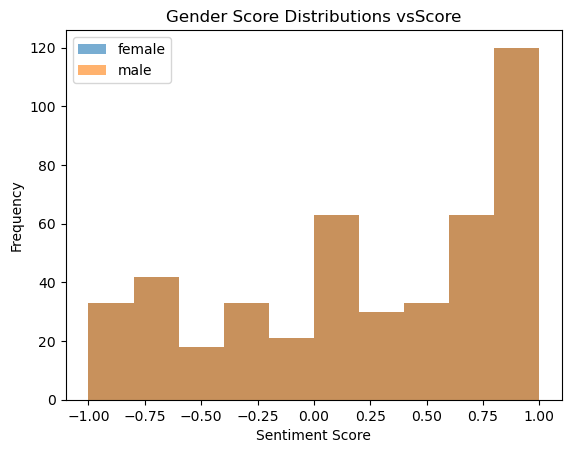

In [54]:
# Plot vaderSentiment score Distributions among races 
plt.hist(woman['vsScore'], range=(-1,1), alpha=0.6, label='female')
plt.hist(man['vsScore'], range=(-1,1), alpha=0.6, label='male')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title("Gender Score Distributions vsScore")
plt.legend()